In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# Pareto tail distribution

$X\sim\text{Pareto}(\alpha, \gamma)$ with pdf

$$
f(x) = \frac{\alpha \gamma^\alpha}{x^{\alpha+1}}
$$

In [2]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logps(self):
        if self.name == "Pareto-Tail":
            def logp_body(X, parms,  γ):
                return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                α = parms[0]
                if α > 0:
                    
                    return(len(X)*( np.log(α) + α * np.log(γ)) - (α + 1) * np.sum(np.log(X)) )
                else:
                    return(-np.inf)
            
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logds(self):
        if self.name == "Pareto-Tail":
            
            def logd_body(x, parms,  γ):
                return(None)
            
            def logd_tail(x, parms,  γ):
                α = parms[:,0]
                res = np.zeros(len(α))
                s = np.logical_and(α > 0, x > γ)
                res[np.where(s)] = np.log(α[s]) + α[s] * np.log(γ[s]) - (α[s] + 1) * np.log(x)
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            self.logd_body = logd_body
            self.logd_tail = logd_tail
    
    def set_cdf(self):
        if self.name == "Pareto-Tail":
            def cdf(parms, γ, x):
                α = parms[0]
                return(1 - (γ / x)**α)
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Pareto-Tail":
            def pdf(parms, γ,  x):
                α = parms[0]
                return(α * γ**α / x**(α + 1))
        self.pdf = nb.jit(nopython = True)(pdf)
                
        
    def set_ppf(self):
        if self.name == "Pareto-Tail":
            def ppf(parms, γ, y):
                α = parms[0]
                return( γ * (1-y)**(-1 / α))
        self.ppf = ppf

In [3]:
par_tail_dist = loss_model("Pareto-Tail", ["α"])
print(par_tail_dist.name, par_tail_dist.parm_names, par_tail_dist.d)
parms = np.array([2])
α = parms
x, y = 2, 0.5
γ = 1.5
par_tail_dist.set_cdf(), par_tail_dist.set_pdf(), par_tail_dist.set_ppf()
par_tail_dist.cdf(parms, γ, γ) - st.pareto(α).cdf(γ / γ), par_tail_dist.ppf(parms, γ, y)-  st.pareto(α).ppf(y) * γ, par_tail_dist.pdf(parms, γ, γ)-  st.pareto(α).pdf(γ / γ) / γ 


Pareto-Tail ['α'] 1


(array([0.]), array([0.]), array([0.]))

In [4]:
X = st.pareto(α).rvs(size = 100) * γ
par_tail_dist.set_logps()
print(par_tail_dist.logp_tail(X, parms, γ)-  np.sum(np.log(st.pareto(α).pdf(X / γ) / γ)))

-1.1368683772161603e-13


In [5]:
X = st.lomax(α).rvs(size = 10) * γ
α_prior, γ_prior= bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('gamma','γ', 1, 1)
prior_gamma_model = bsm.independent_priors([α_prior, γ_prior])
particle_cloud = prior_gamma_model.sample(20)
par_tail_dist.set_logds()
α_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1]
print(par_tail_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) - 
      np.array([np.log(st.pareto(α_vec[i]).pdf(X[0] / γ_vec[i]) / γ_vec[i]) for i in range(len(γ_vec)) ]) )

[           nan            nan            nan            nan
            nan            nan 0.00000000e+00 6.66133815e-16
            nan 0.00000000e+00            nan 7.77156117e-16
            nan            nan            nan 2.22044605e-16
 0.00000000e+00            nan 4.44089210e-16            nan]


C:\Users\pierr\AppData\Local\Temp/ipykernel_6932/1107228768.py:8: RuntimeWarning: divide by zero encountered in log
  np.array([np.log(st.pareto(α_vec[i]).pdf(X[0] / γ_vec[i]) / γ_vec[i]) for i in range(len(γ_vec)) ]) )
C:\Users\pierr\AppData\Local\Temp/ipykernel_6932/1107228768.py:7: RuntimeWarning: invalid value encountered in subtract
  print(par_tail_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -


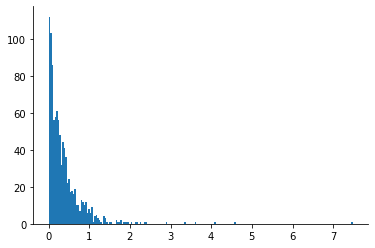

In [6]:
import bayessplicedmodels as bsm
parms_true = np.array([3, 2, 1.6, 0.9])
f1, f2 =  bsm.loss_model("Exp", ["λ1"]), loss_model("Pareto-Tail", ["α2"])
f = bsm.spliced_loss_model(f1 , f2, "continuous") 
X= f.sample(parms_true, 1000) 
plt.hist(X,bins=200)
sns.despine()

In [7]:
λ1_prior = bsm.prior_model('gamma','λ1', 1, 1)
α2_prior = bsm.prior_model('gamma','α2',1, 1)
γ_prior, p_prior =  bsm.prior_model('uniform','γ',min(X), max(X)), bsm.prior_model('beta', 'p', 2, 2)
prior_spliced_model = bsm.independent_priors([λ1_prior,α2_prior, γ_prior])

In [8]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 4000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-uniform prior distribution
Generation: 1 ;temperature: 0.0022821426391601562 ;ESS: 1999 ;steps:3 ;particle moved: 98.925%
Generation: 2 ;temperature: 0.013214973377671413 ;ESS: 1999 ;steps:3 ;particle moved: 99.0%
Generation: 3 ;temperature: 0.06445932232091842 ;ESS: 1999 ;steps:3 ;particle moved: 99.15%
Generation: 4 ;temperature: 0.17256763172335524 ;ESS: 2000 ;steps:3 ;particle moved: 98.85000000000001%
Generation: 5 ;temperature: 0.35662648963600746 ;ESS: 2000 ;steps:3 ;particle moved: 98.85000000000001%
Generation: 6 ;temperature: 0.758018607657599 ;ESS: 2000 ;steps:3 ;particle moved: 99.375%
Generation: 7 ;temperature: 1.0 ;ESS: 3535 ;steps:3 ;particle moved: 99.325%
Wall time: 11.5 s


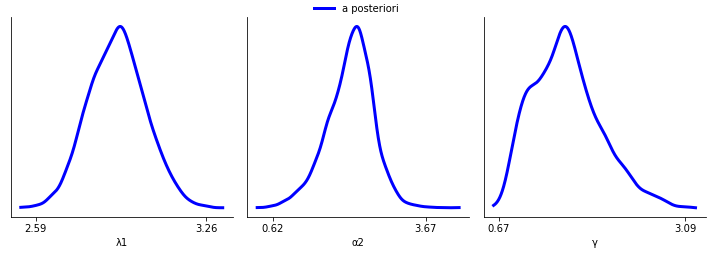

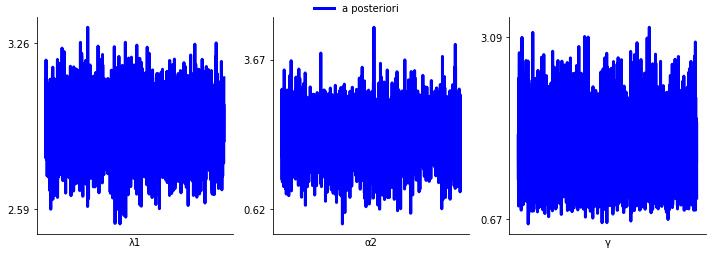

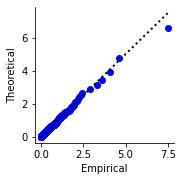

In [10]:
f.set_ppf()
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

## On the danish fire insurance data

In [11]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal", "Burr"]
body_model_param_names = [['λ1'], ["r1", "m1"], ["k1", "β1"], ["μ1", "λ1"], ["μ1", "σ1"], ["α1", "β1", "σ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [[bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1)],
                [bsm.prior_model('gamma',body_model_param_names[1][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[1][1], 1, 1)], 
                [bsm.prior_model('gamma',body_model_param_names[2][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[2][1], 1, 1)],
                [bsm.prior_model('gamma',body_model_param_names[3][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[3][1], 1, 1)],
                [bsm.prior_model('normal',body_model_param_names[4][0], 0, 0.5), bsm.prior_model('gamma',body_model_param_names[4][1], 1, 1)], 
                    [bsm.prior_model('gamma',body_model_param_names[5][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[5][1], 1, 1), bsm.prior_model('gamma',body_model_param_names[5][2], 1, 1)]
]

# Model for the tail of the distribution
tail_model_names = ["Pareto-Tail"]
tail_model_param_names = [["α2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [
                [bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1)]]
γ_prior, p_prior = bsm.prior_model('uniform', "γ", min(X), max(X)), bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))   
for f in fs:
    f.set_ppf()
fs_dict = dict(zip(f_names, fs))

In [12]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 4000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):     
        trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
        return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=4)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))

Wall time: 3min 1s


In [13]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
2,Weibull-Pareto-Tail-continuous,4,0.933271,-3846.941358,7585.819327,7581.469067,9.998551e-01,1170.567874
3,Inverse-Gaussian-Pareto-Tail-continuous,4,1.069138,-3855.872766,7598.530633,7610.871703,1.321527e-04,651.048074
5,Burr-Pareto-Tail-continuous,5,3.621792,-3858.208803,7845.759611,7663.395454,1.278050e-05,1356.251613
1,Gamma-Pareto-Tail-continuous,4,0.956528,-3869.225615,7681.205596,7697.587350,2.098975e-10,1492.591829
4,Lognormal-Pareto-Tail-continuous,4,0.965962,-3871.042640,7689.245788,7711.315208,3.411014e-11,1411.143732
0,Exp-Pareto-Tail-continuous,3,1.831670,-4655.381280,9271.107042,9279.389000,0.000000e+00,865.531524


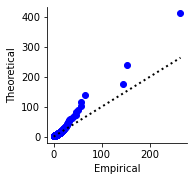

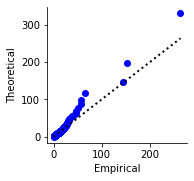

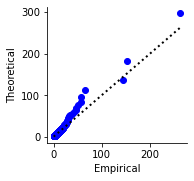

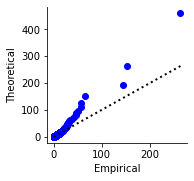

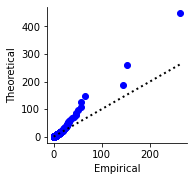

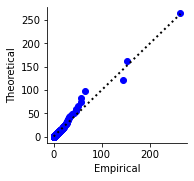

In [14]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"]
for model_name in model_names:
    f, trace = fs_dict[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    # bsm.posterior_plots(f, trace)
    # bsm.trace_plots(f, trace)
    bsm.qq_plot(X, f, trace.mean().values)